---
# Unit08: The Network and Array Methods

This notebook has the activities of the Course **ProSeisSN**. It deals with time series processing using a passive seismic dataset using [ObsPy](https://docs.obspy.org/).

#### Dependencies: Obspy, Numpy, Matplotlib
#### Reset the Jupyter/IPython notebook in order to run it again, press:
***Kernel*** -> ***Restart & Clear Output***
#### The code $\Downarrow$ BELOW $\Downarrow$ runs a notebook with other dependencies

In [1]:
#------ Import Libraries
import sys
import os
    
#------ Work with the directory structure to include auxiliary codes
print('\n Local directory ==> ', os.getcwd())
print('  - Contents: ', os.listdir(), '\n')

path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path+"/CodePy")

%run ../CodePy/ImpMod.ipynb

#------ Alter default matplotlib rcParams
from matplotlib import rcParams
import matplotlib.dates as dates
# Change the defaults of the runtime configuration settings in the global variable matplotlib.rcParams
plt.rcParams['figure.figsize'] = 9, 5
#plt.rcParams['lines.linewidth'] = 0.5
plt.rcParams["figure.subplot.hspace"] = (.9)
plt.rcParams['figure.dpi'] = 100
#------ Magic commands
%matplotlib inline
%matplotlib widget
#%pylab notebook
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

    


 Local directory ==>  /media/jmt/DATA/R-D/COURSES/COPPE_24/Github/Unit08
  - Contents:  ['.ipynb_checkpoints', 'Chap_9.pdf', 'Nbk08.ipynb', 'ttbtide.png'] 

ObsPy version ==> 1.4.1


---
## Use data files from TTB22
- **The Receiver Array**
The array has 24 GS-20DX vertical geophones hooked to a $L=69$m cable, using takeouts spaced $\delta l=6$m from each other. The GS-20DX geophones have a natural frequency of $f_n=10\textrm{Hz}$, and a spurious frequency $f_{sp}>250$Hz. The array has a irregular circular shape, deployed in the Southern tip of the island, with its center at $\left(1^{\circ}12^{\prime}6.93^{\prime\prime}\textrm{S},48^{\circ}30^{\prime}23.39^{\prime\prime}\textrm{S}\right)$. Each of the 24 gather traces are $\Delta T=60$s long, with a sampling frequency of $f_{s}=250$Hz.
- Get geophone locations.

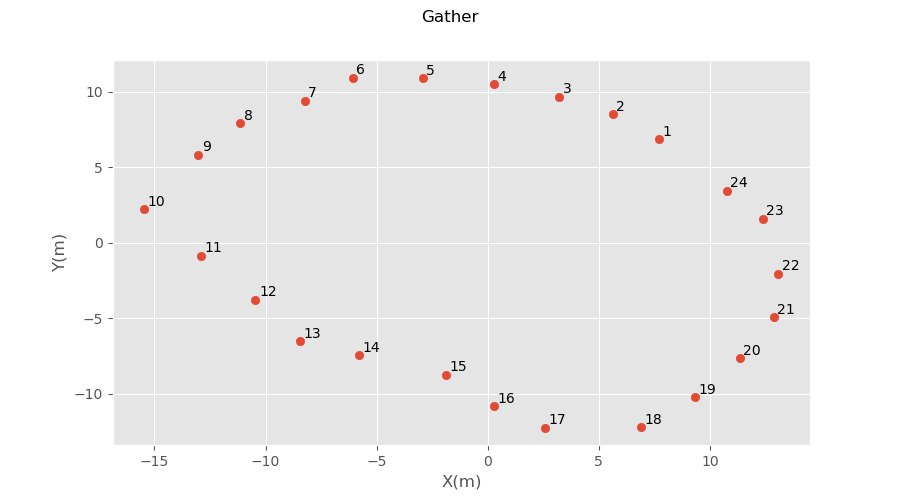

''

In [2]:
#
"""
====================== READ PHONES LOCATIONS ======================
"""
#------ Read the phones cartesian locations
#--- Reads the CSV file with (x, y)m locations
ttb_loc = u.RGloc('../Data/'+'ttb_loc.dat')
#------ Read the phones geographic locations
#--- Reads the CSV file with (lat,lon) in degress locations
ttb_gloc = u.RGloc('../Data/'+'ttb_gloc.dat')
#
#------ Plot gather in cartesian
p.pgather(ttb_loc[:,1], ttb_loc[:,2], ttb_loc[:,0], coord='cartesian')

---
## Read data files from TTB22
- **The data**
Files 3695 to 3810 were collected during 2h ebb tide with an amplitude of 0.91m.
| File | Timestamp | Tide (m) |
| :-: | :-: | :-: |
| 3695 | 2022-04-02T12:00:15 | 2.70 |
| 3810 | 2022-04-02T14:03:06 | 1.79 |
- Let's consider only files ???0.dat: [3700.dat, ..., 3810.dat]

<img src="./ttbtide.png" width="500">

In [3]:
"""
====================== READ THE SEISMIC DATA LOCALLY ======================
"""
#------ Read the seismic data
ent = str(np.random.choice(np.arange(3700, 3811, 10)))
ent = input(f'   Enter a file number in [3695, 3810], rtn=random:\n') or ent
ent = ent.rstrip().split(' ')
print(f">> Read with data file {ent}")
ent = '../Data/ttb/'+ent[0]+'.dat'
#
#------- Read the data file as a SEG2 object

print(ent)
st = read(ent)
#
#------- Print stream information
dummy = float(st[-1].stats.seg2.RECEIVER_LOCATION)
print(f">> Gather acquired on {st[0].stats.starttime}, has {int(st[0].stats.npts)} data points.")

   Enter a file number in [3695, 3810], rtn=random:
 


>> Read with data file ['3790']
../Data/ttb/3790.dat
>> Gather acquired on 2022-04-02T13:41:44.000000Z, has 15000 data points.


---
## Display all the data as a seismogram
- Use the experience with one trace to process the whole stream together.
- A distance dependent plot shows the different move-out of seismic arrivals and gives an idea of the  backazimuth and slowness that could be expected.

>> Baricenter bcenter is at AttribDict({'latitude': -1.201924971512567, 'longitude': -48.506498036629125, 'elevation': 5.0})
>> The mean of 1st original trace is -13.542529197865724
>> Notched original trace from 59.2 to True
>> Useful range due to bandpass 5.0 50.0 filter: 5.0 to 50.0Hz.


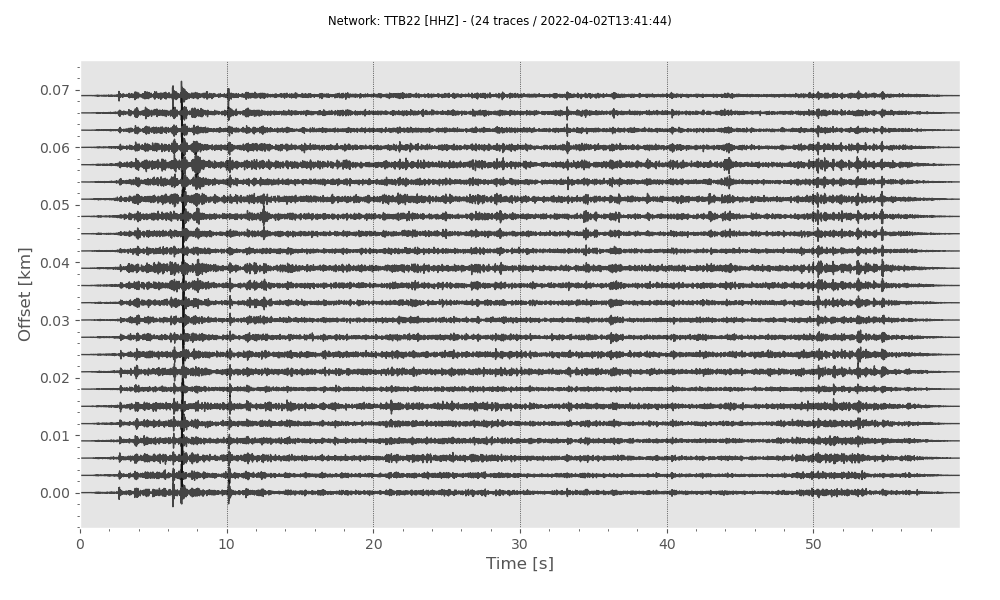

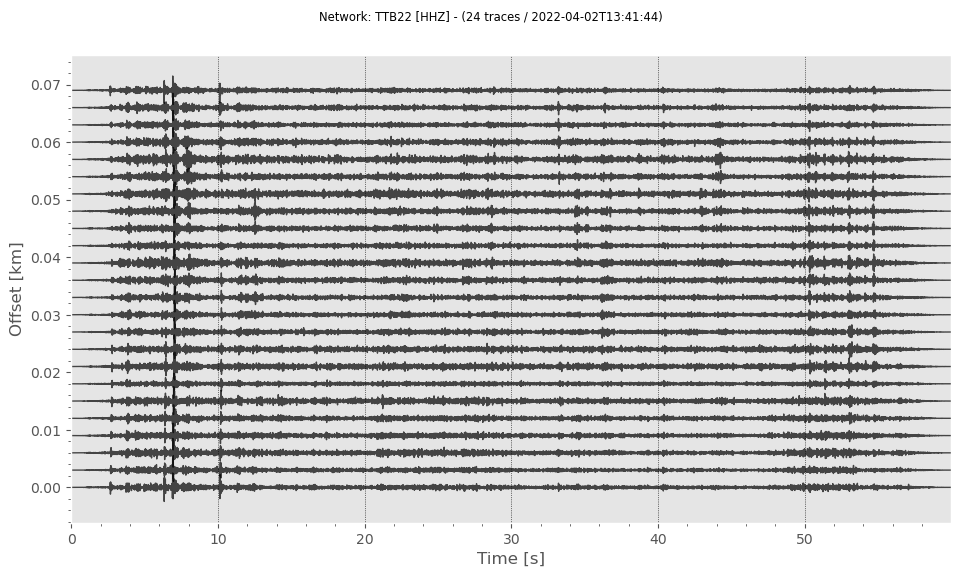

In [4]:
#
#------ Create a new stream from the SEG2 stream. Gather baricenter = bcenter
gather, bcenter = u.creastrm(st, ttb_gloc)
#------- Filter the stream
#--- Filter parameters: change as you choose.
MTparam = [1, 1, 'bp',  5., 50., 1, 0]
# └─────> [dtr, line, ftype, Fmin, Fmax, taper, gain]
gather = u.otrstr(gather, MTparam)
#
#------ Plot
gather.plot(type='section',
            scale=1.3, alpha=.7,
            orientation='horizontal')

 Enter t0 and t1 to zoom:  4 8


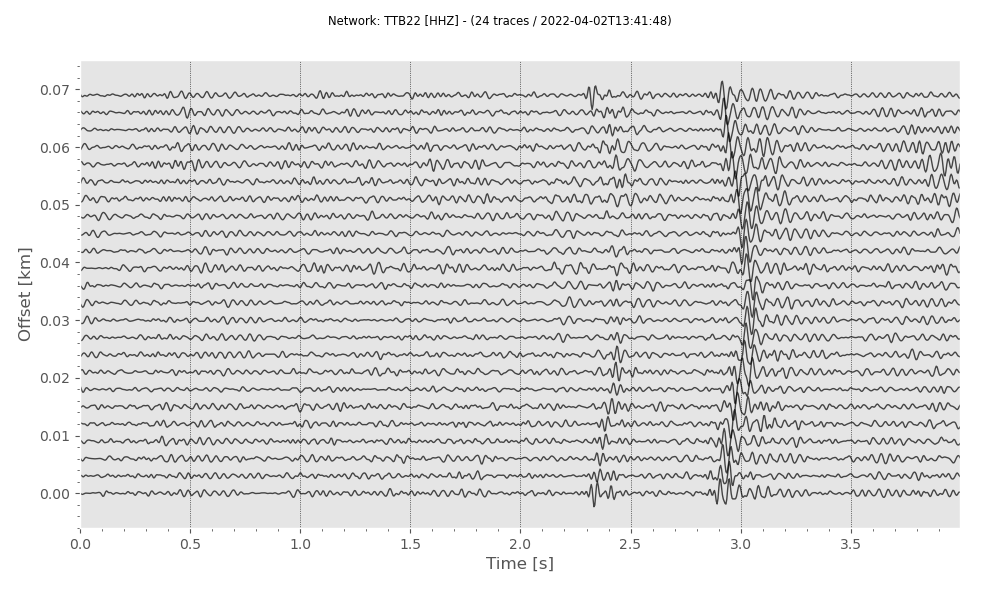

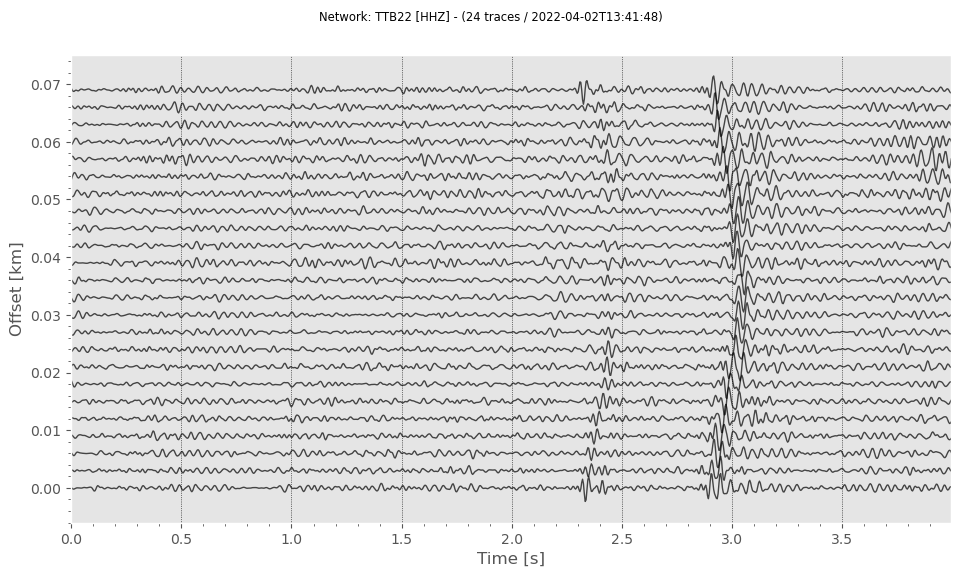

In [5]:
#
#------ Zoom in the seismogram
ent = input(f' Enter t0 and t1 to zoom: ')
ent = ent.rstrip().split(' ')
f0 = float(ent[0])
f1 = float(ent[1])
#
dt = gather[0].stats.starttime
gather.plot(type='section',
            scale=1.3, alpha=.7,
            starttime=dt+f0, endtime=dt+f1,
            orientation='horizontal')

---
### Check frequency contents

 Enter a phone [dflt=random]  


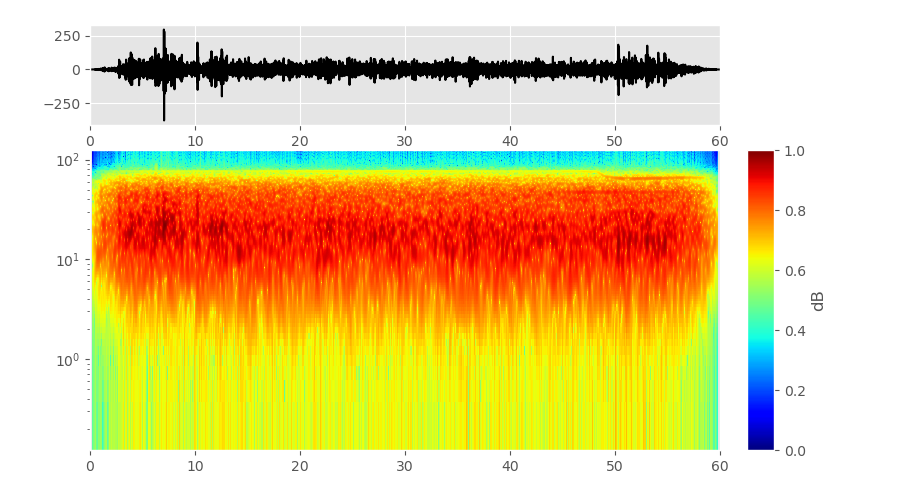

In [6]:
#------ Pick up a phone
dummy = np.random.randint(1, len(st)+1)
ent = input(f' Enter a phone [dflt=random] ')
ent = int( ent.rstrip().split(' ')[0] ) if ent else dummy
#------- The trace
trZ = gather[ent - 1].copy()
#       +───────+─> Trace = Phone -1 
#------ Relative time: nummpy array
time = trZ.times(type="relative")
#------ Plot Trace+Spectrogram
p.Pspect(time, trZ)

---
### Array response
- A good text for this section: Chap_9.pdf.

- We are going to use the ObsPy's FK array analysis modules.

- If $\lambda$ is the wavelength so $\Rightarrow k=\frac{1}{\lambda}$ is the wavenumber. As it goes with frequency, $f=\frac{1}{T}\textrm{ and }\omega=\frac{2\pi}{T}$, so does the wavenumber: $\kappa=\frac{2\pi}{\lambda}$.

- If $v_a$ is the apparent velocity along a given direction and $s$ the slowness, the apparent wavenumber is
$$fs=\frac{f}{v_{a}}=\frac{1}{\lambda_{a}}=k_{a}=\frac{\kappa_{a}}{2\pi}$$

- The array transfer function describes sensitivity and resolution of an array for seismic signals with different frequency range and slownesses $s=\frac{1}{v_a}$.  The array response is the *Fk* spectrum of a monochromatic wave with amplitude $\mathcal{A}=e^{\imath\boldsymbol{k}_{0}\cdot\mathbf{r}}=1$.

- The normalized array response for the Bartlett beamformer is
$$\mathcal{A}\left(f_{0},\boldsymbol{k},\boldsymbol{k}_{0}\right)=\frac{1}{N}\sum_{i=1}^{N}e^{\imath\left(\boldsymbol{k}-\boldsymbol{k}_{0}\right)\cdot\mathbf{r}_{i}}$$

 Enter frequency step from 5.0 to 50.0 [dflt=5.0]  

 Enter -> s_max, s_step(rtn=2.5 0.25): 


Estimating array response between [5.00 : 5.00 : 50.00] Hz


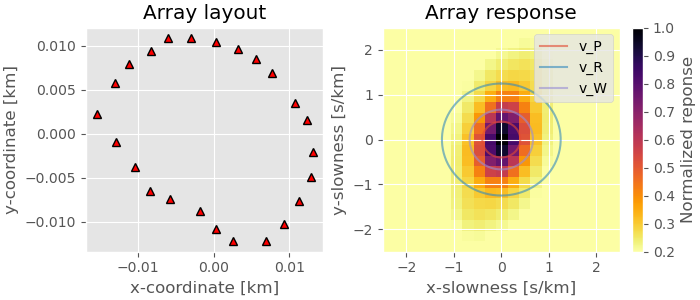

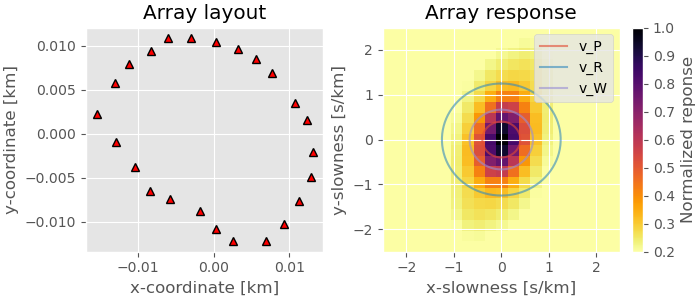

In [7]:
from obspy.signal.array_analysis import array_transff_freqslowness, get_geometry
#from obspy.signal.array_analysis import clibsignal, cosine_taper, get_geometry, get_timeshift
#
#------ Frequency range and step
ent = input(f' Enter frequency step from {MTparam[3]} to {MTparam[4]} [dflt={MTparam[3]}] ') or str(MTparam[3])
ent = float( ent.rstrip().split(' ')[0] )
fstp = float(ent)
#
#------ Slowness maximum and step (s/km)
ent = '2.5 0.25' 
ent = input(f'\n Enter -> s_max, s_step(rtn={ent}):') or ent
ent = ent.rstrip().split(' ')
s_max, s_step = [float(dummy) for dummy in ent]
#
#------ Array geometry
coords = np.zeros((len(gather), 3))
for i, tr in enumerate(gather):
    coords[i,0] = tr.stats.coordinates.latitude
    coords[i,1] = tr.stats.coordinates.longitude
    coords[i,2] = tr.stats.coordinates.elevation
#
#------ Compute array response
print(f'Estimating array response between [{MTparam[3]:.2f} : {fstp:.2f} : {MTparam[4]:.2f}] Hz')
R = array_transff_freqslowness(coords, s_max, s_step, MTparam[3], MTparam[4], fstp, coordsys='lonlat')
#-- Build a grid
sx = np.arange(-s_max, s_max,+s_step)
sy = sx
Sx, Sy = np.meshgrid(sx, sy)
#
#------ Get geometry from ObsPy and plot
geo = get_geometry(gather, coordsys='lonlat', return_center=False, verbose=False)
#
p.par(gather,s_max, R, geo)

---
## Beamforming
- Window length `win_len` (now set to 20 seconds). You want to set the length such that the frequency of interest fits. So larger windows for lower frequencies. And vice versa.
<br/>

- Overlap parameter `win_frac` (now to set to 0.5 for 50% overlap). Choose 0.25 for 75%, 0.1 for 90% overlap, etc. Basically the smaller the parameter, the more overlap and the longer the computation time. 
<br/>

- Slowness grid: you can modify the parameters that define the grid. Parameter `sstep` defines the density of the grid. The smaller the steps, the longer the computation time.

- ObsPy's routines output time, semblance (or relative power), FK power (or absolute power), the back azimuth (in degrees) and slowness (in s/km).

- FK power is the sum of energy on the time-aligned traces. Semblance is the beamformed signal normalized by the ambient power from all other directions-of-arrival.

- I compute the Fisher or $F$-statistic (or $F$-ratio) from the Semblance $S$ as $F = (N-1) \frac{S}{1-S}$. For stationary white Gaussian noise, the Fisher ratio is unity. Basically any deviation means that there is signal.


 Enter t0 and t1 to trim (rtn=do not trim:  0 8


Total time in routine: 50.837711



>> Warning: pltbaz works with VAGAROSITY.



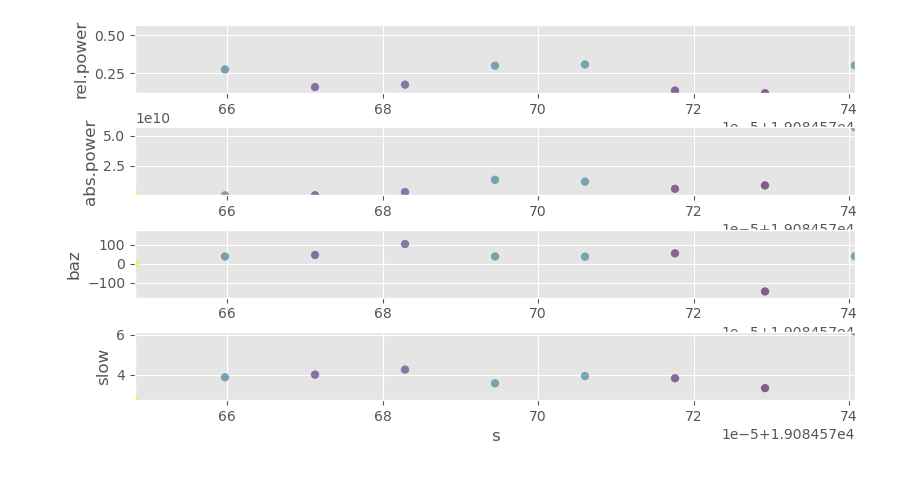

In [44]:
from matplotlib.dates import date2num
import datetime
""" 
    FK analysis with ObsPy. The data is bandpass filtered, prewhitening disabled.
    <Arguments>
    stream               -> ditto
    frqlow, frqhigh      -> Low corner and high corner of frequency range for array analysis
    tstart, tend         -> Relative time limits (s) on the time window for event,
                             later to be transformed to UTCDateTime format.
    wlen                 -> sliding window for analysis in seconds.
    win_frac             -> Overlap fraction (s) fraction. Dflt win_frac = 0.5
    baz_plot             -> Whether to show backazimuth-slowness map (True) or
                             slowness x-y map (False).


    sll_o, sl_s          -> Slowness grid (s/km) and step fraction.
                                      slm_y +─────+
                                            │  .  │
                                            │     │
                                      sll_y +─────+    
                                         sll_x   slm_x
    slx=(min, max)        -> Min/Max slowness for analysis in x direction.
    sly=(min, max)        -> Min/Max slowness for analysis in y direction.
    sls                   -> step width of slowness grid       


    semb_thres, vel_thres -> infinitesimally small numbers; must not be changed.
    timestamp             -> Written in 'matlabday', read directly by plotting routine.
    static3D              -> Static correction of topography (bool) using `vel_corr` as velocity (slow!)
    vel_corr              -> Correction velocity (km/s) for static topography correction

    array_response        -> superimpose array reponse function in plot (bool, slow!)
""" 
#
def sldtw_fk(stream, frqlow, frqhigh, wlen, wfrac=None, baz_plot=True,\
             slx=None, sly=None, sls=None,\
             static_3D=False, vel_corr=None, array_response=False, **kwargs):
#
#------ Auxiliary I/P function
    T = lambda T, t: t if T is None else T
#
#------ Unpack slowness grid
# Min/Max slowness --> note default 5km
    sllx, slmx = T(slx, (-5., 5.))
    slly, slmy = T(sly, (-5., 5.))
#
#------ Time bookends 
    starttime = stream[0].stats.starttime
    endtime   = stream[0].stats.endtime
#--- Dictionary
    sls = T(sls, 0.025)
    kwargs = dict(
#
#------ slowness grid : Xmin , Xmax , Ymin , Ymax , Slow Step --> note default sls=0.025km
    sll_x=sllx, slm_x=slmx, sll_y=slly, slm_y=slmy, sl_s=sls,
#
#------ sliding window properties
#       wlen larger for lower frequencies and vice versa
#       wfrac = 0.5 -> 50%, 0.25 for 75%, 0.1 for 90% overlap
    win_len=wlen, win_frac=T(wfrac, 0.5),
#
#------ Frequency properties
    frqlow=frqlow, frqhigh=frqhigh, prewhiten=0,
#
#------ restrict output
    verbose=False,                                            #store=dump, 
    semb_thres=-1.e9, vel_thres=-1.e9, timestamp='julsec',
#
#------ Time 
    stime=starttime, etime=endtime,
#
        #--- Static correction of topography
#    method=0, correct_3dplane=False           #, static_3D=static_3D      vel_cor=vc,
#
    )
#
#------ Coordinates
    for tr in stream:
        tr.stats.coordinates = AttribDict({
            'latitude': tr.stats.coordinates['latitude'],
            'elevation': tr.stats.coordinates['elevation'],
            'longitude': tr.stats.coordinates['longitude']}
            )
#
#------------ array processing --------------
    start = UTCDateTime()
    out = array_processing(stream, **kwargs)
    print("Total time in routine: %f\n" % (UTCDateTime() - start))
#------ returns 
    return out
#
# -------------- End of function   ---------------------
#
#
# ---------- FK analysis ----------
""" 
----------------MAIN
""" 
#
#------ Trim seismogram
stream = gather.copy()
ent = input(f' Enter t0 and t1 to trim (rtn=do not trim: ')
if ent:
    ent = ent.rstrip().split(' ')
    t0 = gather[0].stats.starttime + float(ent[0])
    t1 = gather[0].stats.starttime + float(ent[1])
    stream.trim(t0, t1)
#
#------ Run
wlen, wfrac = [1., 0.8]
out = sldtw_fk(stream, MTparam[3], MTparam[4], wlen, wfrac=wfrac, baz_plot=True,\
             slx=None, sly=None, sls=None)
#---> wlen = 5 wfrac =0.8 => 10min processing
#
#------ Rework out for plotting
n_instr = len(st)
array_proc = dict()
# array_proc['time'] = mdates.epoch2num(out[:,0])
array_proc['time'] = mdates.date2num(out[:,0])
#array_proc['time'] = matplotlib.dates.date2num(out[:,0])


array_proc['semblance'] = out[:, 1]
array_proc['fk_power'] = out[:, 2]
# Conversion of semblance to Fisher.
array_proc['fisher'] = (n_instr-1)* array_proc['semblance'] / (1-array_proc['semblance'])

array_proc['bazi'] = out[:, 3] % 360
array_proc['app_vel'] = 1e3 / out[:,4]
#
#------------ Plot
#t, rel_power, abs_power, baz, slow = out.T
# -------------- Warning on plots
sys.stdout.write('\n')
print(f'\n>> Warning: pltbaz works with VAGAROSITY.')
sys.stdout.write('\n')
# -------------- Plot graphs
labels = ['rel.power', 'abs.power', 'baz', 'slow']
#    xlocator = mdates.AutoDateLocator()
fig = plt.figure()
for i, lab in enumerate(labels):
  ax = fig.add_subplot(4, 1, i + 1)
#-- Work with velocity instead of vagarosity
#      val = 1./ out[:, i + 1] if lab == 'vel' else out[:, i + 1]
#-- Change x-coord
  dummy = out[-1, 0] - out[0, 0]
  dummy = np.linspace(mdates.date2num(t0), mdates.date2num(t1), num=len(out))

#  dummy = np.linspace(mdates.date2num(starttime), mdates.date2num(endtime),
#                      num=len(out))

  out[:, 0] = dummy.copy()
  ax.scatter(out[:, 0], out[:, i + 1], c=out[:, 1], alpha=0.6,
             edgecolors='none', cmap=obspy_sequential)
#-- Axis limits
  ax.set_ylabel(lab)
  if lab == 'baz':
#        baz[baz < 0.0] += 360                 #backazimuth to values between 0 and 360
    ax.set_ylim(-180,180)
  else:
    ax.set_ylim(out[:, i + 1].min(), out[:, i + 1 ].max())
  ax.set_xlim(out[0, 0], out[-1, 0])

#        ax.xaxis.set_major_locator(xlocator)
#        ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(xlocator))
#  fig.suptitle(title+' %s' % (
#      stime.strftime('%Y-%m-%d'), ))
#    fig.autofmt_xdate()
ax.set_xlabel('s')
fig.subplots_adjust(left=0.15, top=0.95, right=0.95, bottom=0.2, hspace=0.5)
plt.show()


---











 Enter t0 and t1 to trim (rtn=do not trim:  0 8


24 Trace(s) in Stream:

TTB22.1.0.HHZ | 2022-04-02T13:41:44.000000Z - 2022-04-02T13:41:52.000000Z | 250.0 Hz, 2001 samples
...
(22 other traces)
...
TTB22.24.0.HHZ | 2022-04-02T13:41:44.000000Z - 2022-04-02T13:41:52.000000Z | 250.0 Hz, 2001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
Total time in routine: 50.365533

2022-04-02T13:41:44.000000Z


IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

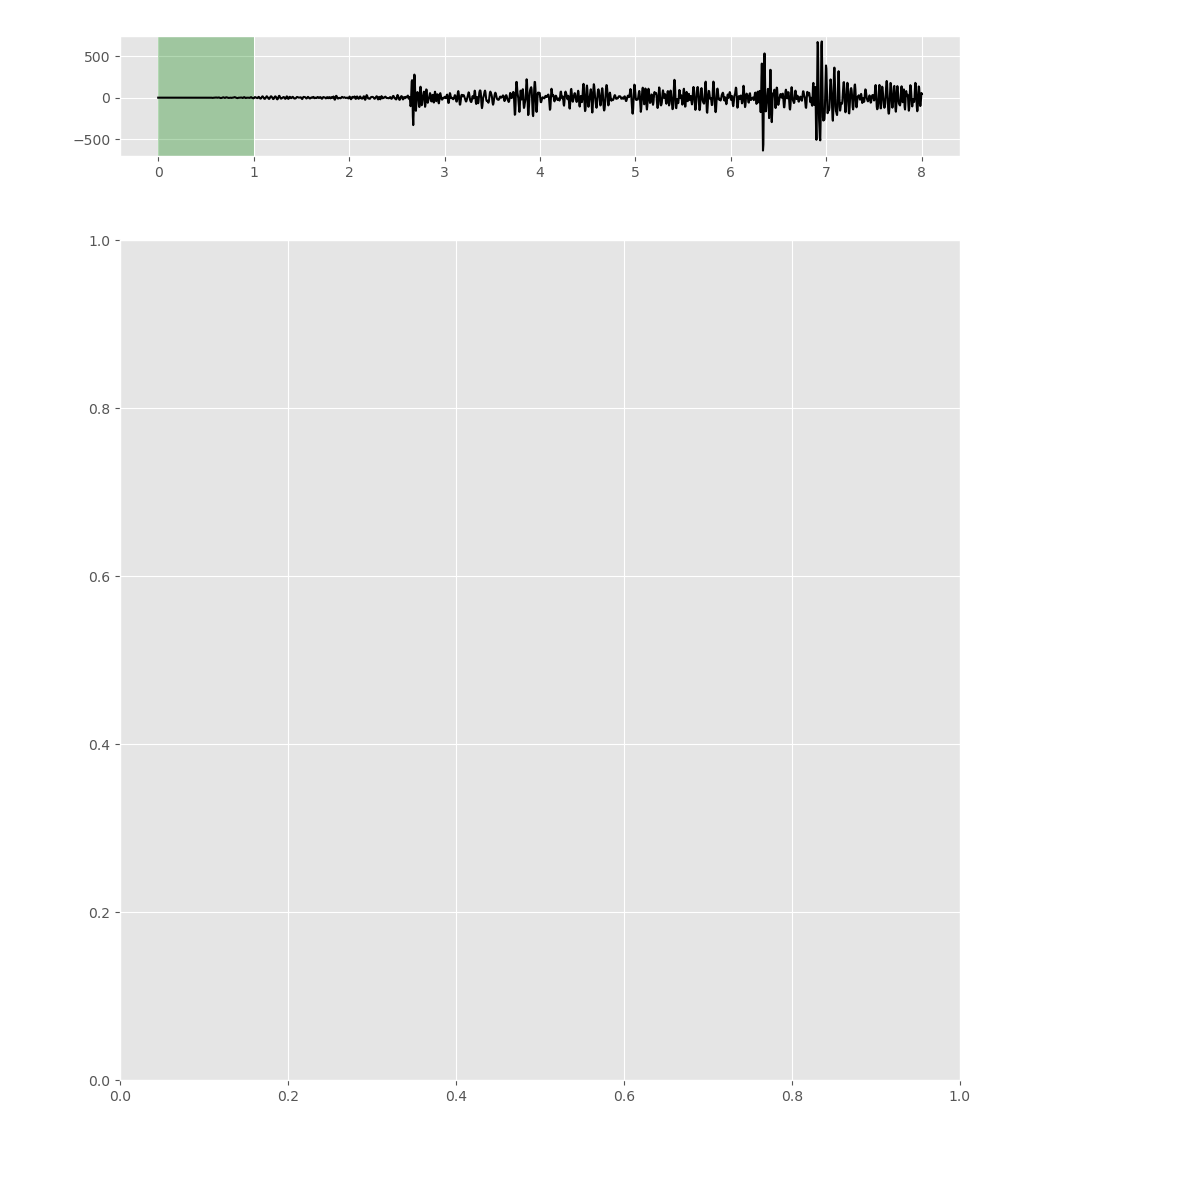

In [43]:
from matplotlib.ticker import MaxNLocator
#
# ---------- FK analysis ----------
""" 
    FK analysis with ObsPy. The data is bandpass filtered, prewhitening disabled.
    <Arguments>
    stream               -> ditto
    frqlow, frqhigh      -> Low corner and high corner of frequency range for array analysis
    tstart, tend         -> Relative time limits (s) on the time window for event,
                             later to be transformed to UTCDateTime format.
    wlen                 -> sliding window for analysis in seconds.
    win_frac             -> Overlap fraction (s) fraction. Dflt win_frac = 0.5
    baz_plot             -> Whether to show backazimuth-slowness map (True) or
                             slowness x-y map (False).


    sll_o, sl_s          -> Slowness grid (s/km) and step fraction.
                                      slm_y +─────+
                                            │  .  │
                                            │     │
                                      sll_y +─────+    
                                         sll_x   slm_x
    slx=(min, max)        -> Min/Max slowness for analysis in x direction.
    sly=(min, max)        -> Min/Max slowness for analysis in y direction.
    sls                   -> step width of slowness grid       


    semb_thres, vel_thres -> infinitesimally small numbers; must not be changed.
    timestamp             -> Written in 'matlabday', read directly by plotting routine.
    static3D              -> Static correction of topography (bool) using `vel_corr` as velocity (slow!)
    vel_corr              -> Correction velocity (km/s) for static topography correction

    array_response        -> superimpose array reponse function in plot (bool, slow!)
""" 
#
def sldtw_fk(stream, frqlow, frqhigh, wlen, wfrac=None, baz_plot=True,\
             slx=None, sly=None, sls=None,\
             static_3D=False, vel_corr=None, array_response=False, **kwargs):
#
#------ Auxiliary I/P function
    T = lambda T, t: t if T is None else T
#
#------ Unpack slowness grid
# Min/Max slowness --> note default 5km
    sllx, slmx = T(slx, (-5., 5.))
    slly, slmy = T(sly, (-5., 5.))
#
#------ Time bookends -> Stream is trimmed -> disabled as all traces have same length
    starttime = max([tr.stats.starttime for tr in stream])
    endtime   = min([tr.stats.endtime for tr in stream])
    stream.trim(starttime, endtime)
#--- Dictionary
    sls = T(sls, 0.025)
    kwargs = dict(
#
#------ slowness grid : Xmin , Xmax , Ymin , Ymax , Slow Step --> note default sls=0.025km
    sll_x=sllx, slm_x=slmx, sll_y=slly, slm_y=slmy, sl_s=sls,
#
#------ sliding window properties
#       wlen larger for lower frequencies and vice versa
#       wfrac = 0.5 -> 50%, 0.25 for 75%, 0.1 for 90% overlap
    win_len=wlen, win_frac=T(wfrac, 0.5),
#
#------ Frequency properties
    frqlow=frqlow, frqhigh=frqhigh, prewhiten=0,
#
#------ restrict output
    verbose=False,                                            #store=dump, 
    semb_thres=-1.e9, vel_thres=-1.e9, timestamp='julsec',
#
#------ Time 
    stime=starttime, etime=endtime,
#
        #--- Static correction of topography
#    method=0, correct_3dplane=False           #, static_3D=static_3D      vel_cor=vc,
#
    )
#
#------ Coordinates
    for tr in stream:
        tr.stats.coordinates = AttribDict({
            'latitude': tr.stats.coordinates['latitude'],
            'elevation': tr.stats.coordinates['elevation'],
            'longitude': tr.stats.coordinates['longitude']}
            )
#
#------ O/P container
    """ 
    filename = ('../data/pow_map.npy',\
               '../data/apow_map.npy')
    def dump(pow_map, apow_map, i):
        np.save(filename[0] % i, pow_map)     #filename_patterns[0]
        np.save(filename[1] % i, apow_map)    #filename_patterns[1]
    """ 
#
    """ 
    try:
        # next step would be needed if the correction velocity needs to be
        # estimated
        #
        sllx /= KM_PER_DEG
        slmx /= KM_PER_DEG
        slly /= KM_PER_DEG
        slmy /= KM_PER_DEG
        sls /= KM_PER_DEG
        vc = vel_corr
    """ 
#
    print(stream)
    spl = stream.copy()
    vc = vel_corr
#
#------------ array processing --------------
    start = UTCDateTime()
    out = array_processing(stream, **kwargs)
    print("Total time in routine: %f\n" % (UTCDateTime() - start))
#
#------ Make output human readable, adjust backazimuth to values
#         between 0 and 360
    t, rel_power, abs_power, baz, slow = out.T
#
    if array_response:
        stepsfreq = (frqhigh - frqlow) / 10.
        tf_slx = sllx
        tf_smx = slmx
        tf_sly = slly
        tf_smy = slmy
        transff = array_transff_freqslowness(
            stream, (tf_slx, tf_smx, tf_sly, tf_smy), sls, frqlow,
            frqhigh, stepsfreq, coordsys='lonlat',
            correct_3dplane=False, static_3D=False, vel_cor=vc)
#
#------------ plotting --------------
#
#------ Color map
    cmap = cm.rainbow
    numslice = len(t)
    powmap = []
    slx = np.arange(sllx-sls, slmx, sls)
    sly = np.arange(slly-sls, slmy, sls)
    if baz_plot:
        maxslowg = np.sqrt(slmx*slmx + slmy*slmy)
        bzs = np.arctan2(sls, np.sqrt(slmx*slmx + slmy*slmy))*180/np.pi
        xi = np.arange(0., maxslowg, sls)
        yi = np.arange(-180., 180., bzs)
        grid_x, grid_y = np.meshgrid(xi, yi)
#
#------ Reading in the rel-power maps
    for i in range(numslice):
        powmap.append(abs_power[i])
    
#    for i in range(numslice):
#        powmap.append(np.load(powmap[0] % i))
#        if method != 'FK':
#            trace.append(np.load(filename[1] % i))
#
#------ 
    npts = stream[0].stats.npts
    df = stream[0].stats.sampling_rate
    T = np.arange(0, npts / df, 1 / df)
#
#------ For windowlen > 0, move through slices
    for i in range(numslice):
        slow_x = np.sin((baz[i]+180.)*np.pi/180.)*slow[i]
        slow_y = np.cos((baz[i]+180.)*np.pi/180.)*slow[i]
        st = UTCDateTime(t[i]) - starttime
        if wlen <= 0:
            en = endtime
        else:
            en = st + wlen
        print(UTCDateTime(t[i])) 
        # add polar and colorbar axes
        fig = plt.figure(figsize=(12, 12))
        ax1 = fig.add_axes([0.1, 0.87, 0.7, 0.10])
        # here we plot the first trace on top of the slowness map
        # and indicate the possibiton of the lsiding window as green box
        method = 'FK'
        if method == 'FK':
            ax1.plot(T, spl[0].data, 'k')
            if wlen > 0.:
                try:
                    ax1.axvspan(st, en, facecolor='g', alpha=0.3)
                except IndexError:
                    pass
        else:
            T = np.arange(0, len(trace[i])/df, 1 / df)
            ax1.plot(T, trace[i], 'k')

        ax1.yaxis.set_major_locator(MaxNLocator(3))

        ax = fig.add_axes([0.10, 0.1, 0.70, 0.7])

        # if we have chosen the baz_plot option a re-griding
        # of the sx,sy slowness map is needed
        if baz_plot:
            slowgrid = []
            transgrid = []
            pow = np.asarray(powmap[i])

            for ix, sx in enumerate(slx):
                for iy, sy in enumerate(sly):
                    bbaz = np.arctan2(sx, sy)*180/np.pi+180.
                    if bbaz > 180.:
                        bbaz = -180. + (bbaz-180.)
                    slowgrid.append((np.sqrt(sx*sx+sy*sy), bbaz,
                                     pow[ix, iy]))
                    if array_response:
                        tslow = (np.sqrt((sx+slow_x) *
                                 (sx+slow_x)+(sy+slow_y) *
                                 (sy+slow_y)))
                        tbaz = (np.arctan2(sx+slow_x, sy+slow_y) *
                                180 / np.pi + 180.)
                        if tbaz > 180.:
                            tbaz = -180. + (tbaz-180.)
                        transgrid.append((tslow, tbaz,
                                          transff[ix, iy]))

            slowgrid = np.asarray(slowgrid)
            sl = slowgrid[:, 0]
            bz = slowgrid[:, 1]
            slowg = slowgrid[:, 2]
            grid = spi.griddata((sl, bz), slowg, (grid_x, grid_y),
                                method='nearest')
            ax.pcolormesh(xi, yi, grid, cmap=cmap)

            if array_response:
                level = np.arange(0.1, 0.5, 0.1)
                transgrid = np.asarray(transgrid)
                tsl = transgrid[:, 0]
                tbz = transgrid[:, 1]
                transg = transgrid[:, 2]
                trans = spi.griddata((tsl, tbz), transg,
                                     (grid_x, grid_y),
                                     method='nearest')
                ax.contour(xi, yi, trans, level, colors='k',
                           linewidth=0.2)

            ax.set_xlabel('slowness [s/deg]')
            ax.set_ylabel('backazimuth [deg]')
            ax.set_xlim(xi[0], xi[-1])
            ax.set_ylim(yi[0], yi[-1])
        else:
            ax.set_xlabel('slowness [s/deg]')
            ax.set_ylabel('slowness [s/deg]')
            slow_x = np.cos((baz[i]+180.)*np.pi/180.)*slow[i]
            slow_y = np.sin((baz[i]+180.)*np.pi/180.)*slow[i]
            ax.pcolormesh(slx, sly, powmap[i].T)
            ax.arrow(0, 0, slow_y, slow_x, head_width=0.005,
                     head_length=0.01, fc='k', ec='k')
            if array_response:
                tslx = np.arange(sllx+slow_x, slmx+slow_x+sls, sls)
                tsly = np.arange(slly+slow_y, slmy+slow_y+sls, sls)
                try:
                    ax.contour(tsly, tslx, transff.T, 5, colors='k',
                               linewidth=0.5)
                except:
                    pass
            ax.set_ylim(slx[0], slx[-1])
            ax.set_xlim(sly[0], sly[-1])
        new_time = t[i]

        result = "BAZ: %.2f, Slow: %.2f s/deg, Time %s" % (
            baz[i], slow[i], UTCDateTime(new_time))
        ax.set_title(result)

        plt.show()
#
#------ returns 
#
# -------------- End of function   ---------------------
#                                      wlen(s)
#
#------ Trim seismogram
stream = gather.copy()
ent = input(f' Enter t0 and t1 to trim (rtn=do not trim: ')
if ent:
    ent = ent.rstrip().split(' ')
    t0 = gather[0].stats.starttime + float(ent[0])
    t1 = gather[0].stats.starttime + float(ent[1])
    stream.trim(t0, t1)
#

wlen, wfrac = [1., 0.8]
sldtw_fk(stream, MTparam[3], MTparam[4], wlen, wfrac=wfrac, baz_plot=True,\
             slx=None, sly=None, sls=None)
#---> wlen = 5 wfrac =0.8 => 10min processing

### Computing DOA with sliding-window array processing

The next code block applies the least-squares method for estimating the DOA in a sliding-window. You can specify the start and end time to process, the length of the time window, and the overlap. The output is a list of times, phase velocities, and backazimuths. The subsequent plot shows the results with the beamformed waveform for comparison.

In [35]:
#
#------ Get the array coordinates
X, stn = u.acoord(gather, bcenter)
#
#------ Enter the sliding-window parameters
print(f'>> Provide the parameters for estimating the DOA with a sliding-window:')
print(f'   1) twin         -> length of the time window;')
print(f'   2) twstep       -> the window step')
print(f'   3) tstart, tend -> the relative start and end times to process;')
#
ent = input(f'<< Enter twin, twstep, tstart, and tend: ') or '1.2 0.2 30 40'
twin, twstep, tstart, tend = np.array(ent.rstrip().split(' '), dtype=float)
#
#------------ 
slid_fk = u.sldtw_fk(gather, tstart, tend, MTparam, win_len=twin, win_frac=twstep)
#------------ Convert times to seconds after Stream start time:
#T = (slid_fk[:,0] - date2num(st[0].stats.starttime.datetime))*86400


#T = (slid_fk[:,0] - date2num(gather[0].stats.starttime.datetime))*86400
T = slid_fk[:,0] - gather[0].times("matplotlib")[0]


#------------ Convert backazimuths to degrees from North:
B = slid_fk[:,3] % 360.
#------------ Convert slowness to phase velocity:
V = 1/slid_fk[:,4]
#------------ Semblance:
S = slid_fk[:,1]
#------------ Plot. Mwax velocity is vmax
vmax =  1.5

ent = input(f'<< Enter a phone: ')
ent = ent.rstrip().split(' ')
p.psw(gather, T, B, V, C=S, v_max=vmax, element=ent[0], twin_plot=[tstart,tend])

#
#------ Get a list of times, phase velocities, and backazimuths
#T, V, B = u.sldtw(gather, X, tstart, tend, twin, overlap)
#
#------ Plot
#st = u.add_beam(gather, bcenter, 'bcenter')
#p.psw(gather, T, B, V, v_max=1., twin_plot=[tstart,tend])


>> Provide the parameters for estimating the DOA with a sliding-window:
   1) twin         -> length of the time window;
   2) twstep       -> the window step
   3) tstart, tend -> the relative start and end times to process;


<< Enter twin, twstep, tstart, and tend:  


AttributeError: module 'utils' has no attribute 'sldtw_fk'

---


In [ ]:
ent = int(ent) - 1
flims = [MTparam[3], MTparam[4]]
"""
====================== BEAMFORMING ======================
"""
stream = Stream()
dummy  = Stream([gather[ent]])
print(len(dummy))
# ---------- Use FK Analysis
out, stime, etime = u.BeamFK(dummy, flims, ttb_gloc)
#-- Make output human readable
t, rel_power, abs_power, baz, slow = out.T
#------------- print
sys.stdout.write('\n')
print(f'>> t       rel_power abs_power   baz(deg) slow(s/km)')    
for i in range(len(t)):
    print(f'   {round(t[i],4)}, {round(rel_power[i],4)}, {round(abs_power[i],4)}, {round(baz[i],4)}, {round(slow[i],4)}')    
#------------ Plot
p.pltbaz(out, stime , etime)



---
